In [2]:
import numpy as np
import popstatgen as psg
import matplotlib.pyplot as plt
import copy

In [8]:
# plotting functions
def plot_GRM_halves(A_half1, A_half2):
    '''
    Makes a 2D histogram (heatmap) of the corresponding values in the the two half-GRMs (or any 2 GRMs)
    '''
    # code adapted from here:
    # https://stackoverflow.com/questions/2369492/generate-a-heatmap-using-a-scatter-data-set
    heatmap, xedges, yedges = np.histogram2d(A_half1[np.triu_indices_from(A_half1, k=1)], # upper triangle without diagonal
                                             A_half2[np.triu_indices_from(A_half2, k=1)], # upper triangle without diagonal
                                             bins=50)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    plt.clf() # clears plot
    # adds vertical and horizontal lines at 0 underneath the heatmap
    plt.axhline(0, color='k', lw=1)
    plt.axvline(0, color='k', lw=1)

    # add heatmap using logarithm of counts
    plt.imshow(np.log1p(heatmap.T), extent=extent, origin='lower', aspect='auto', cmap='Blues')
    
    # add legends/labels
    plt.colorbar(label='log(count + 1)')
    plt.xlabel('GRM value from the genotyped variants')
    plt.ylabel('GRM value from the ungenotyped variants')

    plt.show()

In [5]:
# generates population
M = 10_000 # number of variants
N = 5_000 # population size
pop1 = psg.Population(N=N, M=M, keep_past_generations = 2)
# makes all variants independent from each other (LD = 0)
pop1.make_sites_indep()

# adds a trait with heritability 0.5, with all variants being causal with equal effects
pop1.add_trait(name='y', var_G = 0.5, var_Eps = 0.5, dist = 'constant', M_causal = M)
# the true heritability, defined as ratio of genetic variance to phenotypic variance
print(f'True h2 = {pop1.traits["y"].h2_true}')

True h2 = 0.5163735198748257


In [6]:
# compute the genetic relationship matrix (GRM) using all variants
A1 = psg.pop.compute_GRM(pop1.X)
# running REML to estimate h2 based on phenotypic covariance structure implied by the GRM
# we expect the estimate to be close to the true h2 = 0.5
out_REML1 = psg.stat.run_REML(y = pop1.traits['y'].y, X = None,  # no fixed effects
                  Bs = [A1], # GRM
                  Zs = [None], # identity matrix
                  init = None,
                  method = 'AI', tol=1e-4, max_iter=50)
h2_REML1 = out_REML1['var_components'][0] / np.sum(out_REML1['var_components'])
h2_REML1_CI = h2_REML1 + np.array([-1.96, 1.96]) * out_REML1['var_components_se'][0] # 95% CI
print(f'REML h2 = {h2_REML1}, {h2_REML1_CI}' )

Iteration 1, Random Effect 1: Updated variance component = 0.724391, Offset = -0.182646
Iteration 2, Random Effect 1: Updated variance component = 0.549003, Offset = -0.175388
Iteration 3, Random Effect 1: Updated variance component = 0.503788, Offset = -0.045215
Iteration 4, Random Effect 1: Updated variance component = 0.499588, Offset = -0.004200
Iteration 5, Random Effect 1: Updated variance component = 0.499456, Offset = -0.000133
Iteration 6, Random Effect 1: Updated variance component = 0.499453, Offset = -0.000003
Converged after 6 iterations.
REML h2 = 0.4982091270295094, [0.43484502 0.56157324]


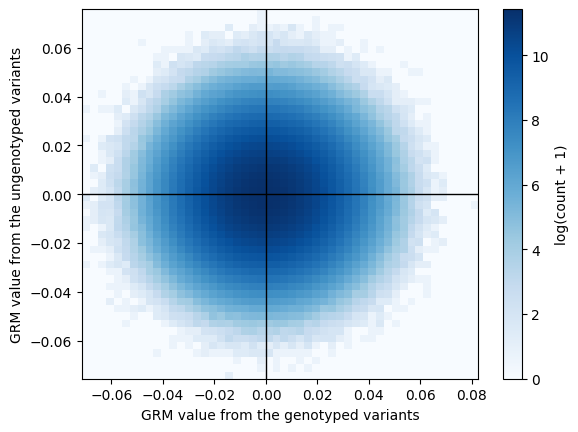

In [9]:
# now let's say that our genotyping array only captures half of the causal variants
# (for simplicity, we just use the first half of the variants)
# we can compute a GRM using only the genotyped variants
# as well as the un-genotyped variants
A1_half1  = psg.pop.compute_GRM(pop1.X[:, :M//2]) # GRM constructed from just first half the variants
A1_half2 = psg.pop.compute_GRM(pop1.X[:, M//2 :]) # GRM constructed from just second half the variants

# plots the GRM values from the two halves against each other
plot_GRM_halves(A1_half1, A1_half2)

In [10]:
# the the two GRMs are independent from each other, demonstrated by the giant blob of points around (0,0)
# in other words, the genotyped variants do not give us information about the ungenotyped variants
# and so the relatedness of two individuals based on the genotyped variants
# does not tell us anything about their relatedness based on the ungenotyped variants

# so the REML estimate of h2 using just the genotyped variants' GRM will
# only be able to capture the contribution of the genotyped variants
# this is called the h2g (SNP heritability)
out_REML2 = psg.stat.run_REML(y = pop1.traits['y'].y, X = None,  # no fixed effects
                  Bs = [A1_half1],
                  Zs = [None], # identity matrix
                  init = None,
                  method = 'AI', tol=1e-4, max_iter=50)
h2_REML2 = out_REML2['var_components'][0] / np.sum(out_REML2['var_components'])
h2_REML2_CI = h2_REML2 + np.array([-1.96, 1.96]) * out_REML2['var_components_se'][0]
print(f'REML h2 (h2g) = {h2_REML2}, {h2_REML2_CI}' )

Iteration 1, Random Effect 1: Updated variance component = 0.393037, Offset = -0.301840
Iteration 2, Random Effect 1: Updated variance component = 0.266601, Offset = -0.126435
Iteration 3, Random Effect 1: Updated variance component = 0.234719, Offset = -0.031882
Iteration 4, Random Effect 1: Updated variance component = 0.232567, Offset = -0.002152
Iteration 5, Random Effect 1: Updated variance component = 0.232551, Offset = -0.000016
Converged after 5 iterations.
REML h2 (h2g) = 0.23253819450028854, [0.18600838 0.27906801]


In [12]:
# now we will simulate related individuals by going forward 2 generations
# allowing for related offspring to inherit half their DNA from each parent
# this should generate siblings (K = 0.5) and cousins (K = 0.125)
pop2 = copy.deepcopy(pop1)
pop2.simulate_generations(generations=2, related_offspring=True)
# and we will combine the previous generation into the current
# making a larger, multigenerational population (2 generations)
pop3 = pop2.flatten_generations(generations=1)
# the trait has to be re-added to the new population
# we'll reuse the same effect sizes as before
pop3.add_trait_from_effects(name='y', effects = pop1.traits['y'].effects, var_Eps = 0.5)
print(f'True h2 = {pop3.traits["y"].h2_true}') # true heritability

True h2 = 0.5045702719451555


In [13]:
# recompute GRM using all variants
A2 = psg.pop.compute_GRM(pop3.X)

# computing the REML h2 from the full GRM still gets us back the true h2
out_REML3 = psg.stat.run_REML(y = pop3.traits['y'].y, X = None,  # no fixed effects
                  Bs = [A2], # GRM
                  Zs = [None], # identity matrix
                  init = None,
                  method = 'AI', tol=1e-4, max_iter=50)
h2_REML3 = out_REML3['var_components'][0] / np.sum(out_REML3['var_components'])
h2_REML3_CI = h2_REML3 + np.array([-1.96, 1.96]) * out_REML3['var_components_se'][0]
print(f'REML h2 = {h2_REML3}, {h2_REML3_CI}' )

Iteration 1, Random Effect 1: Updated variance component = 0.496740, Offset = -0.155100
Iteration 2, Random Effect 1: Updated variance component = 0.483137, Offset = -0.013603
Iteration 3, Random Effect 1: Updated variance component = 0.482839, Offset = -0.000299
Iteration 4, Random Effect 1: Updated variance component = 0.482880, Offset = 0.000041
Converged after 4 iterations.
REML h2 = 0.4875427106756706, [0.45097316 0.52411226]


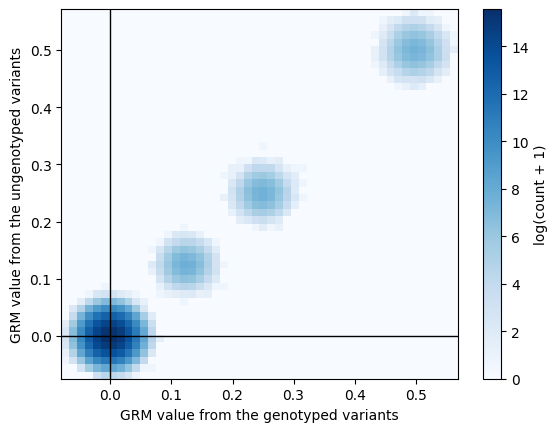

In [14]:
# now we'll recompute the GRM using each half of the variants
A2_half1 = psg.pop.compute_GRM(pop3.X[:, :M//2])
A2_half2 = psg.pop.compute_GRM(pop3.X[:, M//2 :])
# plots the GRM values from the two halves against each other
plot_GRM_halves(A2_half1, A2_half2)

In [15]:
# we see that the two half-GRMs are correlated with each other
# driven by the different possible relationships in the dataset (siblings, parents, uncles/aunts, cousins)

# computing h2 using just one half of the variants
# now gives us a value of h2 that will be slightly higher than half the true h2
# due to the related individuals with correlated GRMs
# however, since there are still so many unrelated individuals,
# the estimate will still be lower than the true h2
out_REML4 = psg.stat.run_REML(y = pop3.traits['y'].y, X = None,  # no fixed effects
                  Bs = [A2_half1], # GRM
                  Zs = [None], # identity matrix
                  init = None,
                  method = 'AI', tol=1e-4, max_iter=50)
h2_REML4 = out_REML4['var_components'][0] / np.sum(out_REML4['var_components'])
h2_REML4_CI = h2_REML4 + np.array([-1.96, 1.96]) * out_REML4['var_components_se'][0]
print(f'REML h2 (somewhere between h2 and h2g) = {h2_REML4}, {h2_REML4_CI}' )

Iteration 1, Random Effect 1: Updated variance component = 0.332434, Offset = 0.029970
Iteration 2, Random Effect 1: Updated variance component = 0.331851, Offset = -0.000583
Iteration 3, Random Effect 1: Updated variance component = 0.331878, Offset = 0.000027
Converged after 3 iterations.
REML h2 (somewhere between h2 and h2g) = 0.3332762769014412, [0.30245708 0.36409547]


In [16]:
# instead, let's make a thresholded half GRM, where those with GRM < threshold are set to 0
GRM_threshold = 0.05
A2_half1_thresh = A2_half1.copy()
A2_half1_thresh[A2_half1_thresh <= GRM_threshold] = 0

# now, the REML estimate of h2 using this thresholded GRM will be much closer to the true h2
# because the heritability estimate is fully driven by the related individuals
# whose half-GRM is strongly correlated with the other half-GRM
# thus giving information about all the variants
out_REML5 = psg.stat.run_REML(y = pop3.traits['y'].y, X = None,  # no fixed effects
                  Bs = [A2_half1_thresh], # GRM
                  Zs = [None], # identity matrix
                  init = None,
                  method = 'AI', tol=1e-4, max_iter=50)
h2_REML5 = out_REML5['var_components'][0] / np.sum(out_REML5['var_components'])
h2_REML5_CI = h2_REML5 + np.array([-1.96, 1.96]) * out_REML5['var_components_se'][0]
print(f'REML h2 = {h2_REML5}, {h2_REML5_CI}' )

Iteration 1, Random Effect 1: Updated variance component = 0.485560, Offset = -0.122138
Iteration 2, Random Effect 1: Updated variance component = 0.488320, Offset = 0.002760
Iteration 3, Random Effect 1: Updated variance component = 0.488425, Offset = 0.000105
Iteration 4, Random Effect 1: Updated variance component = 0.488423, Offset = -0.000002
Converged after 4 iterations.
REML h2 = 0.49040651399932395, [0.44616636 0.53464667]


In [17]:
# what if we are interested in getting back both h2 and h2g?
# we can fit both the thresholded half GRM and the non-thresholded GRM
out_REML6 = psg.stat.run_REML(y = pop3.traits['y'].y, X = None,  # no fixed effects
                  Bs = [A2_half1_thresh, A2_half1], # GRMs
                  Zs = [None, None], # identity matrices
                  init = None,
                  method = 'AI', tol=1e-4, max_iter=50)
comp6 = out_REML6['var_components']
h2g_REML6 = comp6[1] / np.sum(comp6)
h2g_REML6_CI = h2g_REML6 + np.array([-1.96, 1.96]) * out_REML6['var_components_se'][1]
print(f'REML h2g = {h2g_REML6}, {h2g_REML6_CI}' )

h2_REML6 = (comp6[0] + comp6[1]) / np.sum(comp6)
vcov6 = out_REML6['var_components_vcov']
h2_REML6_se = np.sqrt( (vcov6[0,0] + vcov6[1,1] + 2*vcov6[0,1]) / np.sum(comp6)**2 )
h2_REML6_CI = h2_REML6 + np.array([-1.96, 1.96]) * h2_REML6_se
print(f'REML h2 = {h2_REML6}, {h2_REML6_CI}' )

Iteration 1, Random Effect 1: Updated variance component = 0.450165, Offset = -0.014593
Iteration 1, Random Effect 2: Updated variance component = 0.300568, Offset = -0.139267
Iteration 2, Random Effect 1: Updated variance component = 0.309386, Offset = -0.140779
Iteration 2, Random Effect 2: Updated variance component = 0.235257, Offset = -0.065311
Iteration 3, Random Effect 1: Updated variance component = 0.259950, Offset = -0.049436
Iteration 3, Random Effect 2: Updated variance component = 0.230155, Offset = -0.005103
Iteration 4, Random Effect 1: Updated variance component = 0.257709, Offset = -0.002241
Iteration 4, Random Effect 2: Updated variance component = 0.230238, Offset = 0.000083
Iteration 5, Random Effect 1: Updated variance component = 0.257801, Offset = 0.000092
Iteration 5, Random Effect 2: Updated variance component = 0.230271, Offset = 0.000032
Converged after 5 iterations.
REML h2g = 0.23136416875680232, [0.19958946 0.26313888]
REML h2 = 0.4903898603294331, [0.4471